In [14]:
#from umap import UMAP
#import hdbscan
#from hdbscan import HDBSCAN
import pickle

from pymethylprocess.MethylationDataTypes import MethylationArray
from pymethylprocess.general_machine_learning import MachineLearning
import pandas as pd, numpy as np
from sklearn.decomposition import PCA
import matplotlib, matplotlib.pyplot as plt
import seaborn as sns
from seaborn import cubehelix_palette
import pandas as pd
from sklearn.preprocessing import LabelEncoder
sns.set()

## Load Data

In [29]:
train_methyl_array=MethylationArray.from_pickle("/mnt/c/Users/bless/OneDrive/MS_Studies/AML/GSE189778/train_methyl_array.pkl")
val_methyl_array=MethylationArray.from_pickle("/mnt/c/Users/bless/OneDrive/MS_Studies/AML/GSE189778/val_methyl_array.pkl")
test_methyl_array=MethylationArray.from_pickle("/mnt/c/Users/bless/OneDrive/MS_Studies/AML/GSE189778/test_methyl_array.pkl")

In [30]:
print(train_methyl_array.pheno['disease'])

GSM5707050_9305216209_R01C01        Neuropathology, Heidelberg
GSM5707144_101231000026_R02C02                          Others
GSM5707099_200091640051_R04C01                          Others
GSM5707123_9297949139_R02C01      Neuropathology, WWU Muenster
GSM5707066_9553932123_R05C02         Neuropathology, Tuebingen
                                              ...             
GSM5707055_9296930031_R06C02          Neuropathology, Erlangen
GSM5707044_9007225017_R05C01          Neuropathology, Erlangen
GSM5707026_101231000003_R06C02                          Others
GSM5707029_9426021162_R02C01          Neuropathology, Erlangen
GSM5707111_9741950120_R03C02                            Others
Name: disease, Length: 82, dtype: object


In [31]:
print(test_methyl_array.pheno['disease'])

GSM5707023_9741950008_R03C01        Neuropathology, Heidelberg
GSM5707024_9878827235_R04C02        Neuropathology, Heidelberg
GSM5707036_9426021162_R04C02          Neuropathology, Erlangen
GSM5707042_9296930031_R05C02          Neuropathology, Erlangen
GSM5707043_9407201032_R06C02          Neuropathology, Erlangen
GSM5707045_9305651037_R04C02        Neuropathology, Heidelberg
GSM5707051_9305216209_R01C02        Neuropathology, Heidelberg
GSM5707059_9296930094_R03C02          Neuropathology, Erlangen
GSM5707073_9007225163_R03C01       Neuropathology, UKE Hamburg
GSM5707074_200091640051_R05C01     Neuropathology, UKE Hamburg
GSM5707082_9878827235_R06C01      Neuropathology, LMU Muenchen
GSM5707093_9422491056_R01C02      Neuropathology, LMU Muenchen
GSM5707096_200091640051_R03C02                          Others
GSM5707104_9741950120_R04C02                            Others
GSM5707108_9741950120_R05C02                            Others
GSM5707109_9422491056_R03C02      Neuropathology, LMU M

In [32]:
print(val_methyl_array.pheno['disease'])

GSM5707075_9741950120_R01C01       Neuropathology, UKE Hamburg
GSM5707040_9426021162_R03C02          Neuropathology, Erlangen
GSM5707090_9422491056_R05C02      Neuropathology, LMU Muenchen
GSM5707034_9426021162_R06C01                            Others
GSM5707077_9376561042_R05C01      Neuropathology, LMU Muenchen
GSM5707047_9296930094_R04C02          Neuropathology, Erlangen
GSM5707110_9741950111_R05C02                            Others
GSM5707076_9878827221_R05C01      Neuropathology, LMU Muenchen
GSM5707113_9007225163_R02C01                            Others
GSM5707070_9376538153_R06C02                            Others
GSM5707134_101231000005_R03C01                          Others
GSM5707085_9878827221_R02C02      Neuropathology, LMU Muenchen
Name: disease, dtype: object


In [38]:
all_disease_values = pd.concat([train_methyl_array.pheno['disease'], val_methyl_array.pheno['disease'], test_methyl_array.pheno['disease']])
disease_counts = all_disease_values.value_counts()
print(disease_counts)

Others                          46
Neuropathology, LMU Muenchen    24
Neuropathology, Erlangen        22
Neuropathology, Heidelberg      10
Neuropathology, UKE Hamburg      8
Neuropathology, Tuebingen        3
Neuropathology, WWU Muenster     3
Pathology, USB Basel             1
Name: disease, dtype: int64


## Supervised Model

In [42]:
#encoding the labels of the data

encoding_mapping = {
    'Others': 1,
    'Neuropathology, LMU Muenchen': 2,
    'Neuropathology, Erlangen': 3,
    'Neuropathology, Heidelberg': 4,
    'Neuropathology, UKE Hamburg': 5,
    'Neuropathology, Tuebingen': 6,
    'Neuropathology, WWU Muenster': 7,
    'Pathology, USB Basel': 8,
}

# Encode the target variable using the mapping
train_methyl_array.pheno['disease'] = train_methyl_array.pheno['disease'].map(encoding_mapping)
val_methyl_array.pheno['disease'] = val_methyl_array.pheno['disease'].map(encoding_mapping)
test_methyl_array.pheno['disease'] = test_methyl_array.pheno['disease'].map(encoding_mapping)


In [28]:
print(val_methyl_array.pheno['disease']) #to test

GSM5707075_9741950120_R01C01      2
GSM5707040_9426021162_R03C02      0
GSM5707090_9422491056_R05C02      1
GSM5707034_9426021162_R06C01      3
GSM5707077_9376561042_R05C01      1
GSM5707047_9296930094_R04C02      0
GSM5707110_9741950111_R05C02      3
GSM5707076_9878827221_R05C01      1
GSM5707113_9007225163_R02C01      3
GSM5707070_9376538153_R06C02      3
GSM5707134_101231000005_R03C01    3
GSM5707085_9878827221_R02C02      1
Name: disease, dtype: int64


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

y_pred = {}
scores={}
model=MachineLearning(RandomForestRegressor,options={})
model.fit(train_methyl_array,val_methyl_array,'disease')
y_pred['train']=model.predict(train_methyl_array)
y_pred['val']=model.predict(val_methyl_array)
y_pred['test']=model.predict(test_methyl_array)

scores['train']=r2_score(train_methyl_array.pheno['disease'],y_pred['train'])
scores['val']=r2_score(val_methyl_array.pheno['disease'],y_pred['val'])
scores['test']=r2_score(test_methyl_array.pheno['disease'],y_pred['test'])
scores

{'train': 0.9026011255882145,
 'val': -3.540996923076923,
 'test': -0.5701064755838643}

Since the data that was being predicted was by using a Regressor instead of the Classifier, we assumed that changing the model to classifier will incread the scores.

In [12]:
data=pd.DataFrame(model.model.feature_importances_,columns=['Importance'])
data=data.sort_values('Importance').iloc[::-1]
data['sample']=np.arange(len(data.index))

In [13]:
data

,Importance,sample
78110,0.038948,0
84044,0.035504,1
207441,0.032396,2
11649,0.027308,3
163810,0.026311,4
...,...,...
199834,0.000000,299995
199835,0.000000,299996
199836,0.000000,299997
199837,0.000000,299998


### Analaysis using RF Classifier

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
import numpy as np
import pandas as pd
from sklearn.preprocessing import label_binarize


In [61]:
train_methyl_array=pd.read_pickle("C:/Users/shubh/Downloads/pkl/train_methyl_array.pkl")
val_methyl_array=pd.read_pickle("C:/Users/shubh/Downloads/pkl/val_methyl_array.pkl")
test_methyl_array=pd.read_pickle("C:/Users/shubh/Downloads/pkl/test_methyl_array.pkl")

In [62]:
beta_train = train_methyl_array['beta']
beta_val = val_methyl_array['beta']
beta_test = test_methyl_array['beta']

pheno_train = train_methyl_array['pheno']
pheno_val = val_methyl_array['pheno']
pheno_test = test_methyl_array['pheno']

In [63]:
concatenated_pheno = pd.concat([pheno_train, pheno_val, pheno_test], ignore_index=False)
concatenated_beta = pd.concat([beta_train, beta_val, beta_test], ignore_index=False)


In [64]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
concatenated_pheno['disease_enc'] = label_encoder.fit_transform(concatenated_pheno['disease'])


In [65]:
pheno_train = concatenated_pheno[:len(pheno_train)]
pheno_val = concatenated_pheno[len(pheno_train): len(pheno_train) + len(pheno_val)]
pheno_test = concatenated_pheno[len(pheno_train) + len(pheno_val):]


In [66]:
train_methyl_array['pheno'] = pheno_train
val_methyl_array['pheno'] = pheno_val
test_methyl_array['pheno'] = pheno_test 

In [67]:
X_train = train_methyl_array['beta']
X_test = test_methyl_array['beta']
X_val = val_methyl_array['beta']
Y_train = train_methyl_array['pheno']['disease_enc']
Y_test= test_methyl_array['pheno']['disease_enc']
Y_val = val_methyl_array['pheno']['disease_enc']

In [68]:
n_estimators_list = [50, 100, 500, 750, 1000]
for n_estimators in n_estimators_list:
    # Initialize the Random Forest Classifier
    model = RandomForestClassifier(n_estimators=n_estimators, max_features=8, n_jobs=-1, random_state=1)

    # Fit the classifier on the training data
    model.fit(X_train, Y_train)

    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    scores_train = r2_score(Y_train,y_pred_train)
    scores_val = r2_score(Y_val,y_pred_val)
    scores_test = r2_score(Y_test,y_pred_test)
    print("n_estimators=",n_estimators)
    print("\nscores_train\tscores_val\tscores_test")
    print(scores_train,"\t",scores_val,"\t",scores_test)
    print('---------------------------------------------------------')

n_estimators= 50

scores_train	scores_val	scores_test
1.0 	 -0.44374999999999964 	 -0.5387963663890987
---------------------------------------------------------
n_estimators= 100

scores_train	scores_val	scores_test
1.0 	 -0.22499999999999987 	 -0.5432437547312636
---------------------------------------------------------
n_estimators= 500

scores_train	scores_val	scores_test
1.0 	 0.5625 	 -0.48542770628311827
---------------------------------------------------------
n_estimators= 750

scores_train	scores_val	scores_test
1.0 	 0.5625 	 -0.48542770628311827
---------------------------------------------------------
n_estimators= 1000

scores_train	scores_val	scores_test
1.0 	 0.5625 	 -0.5343489780469337
---------------------------------------------------------


since the scores were pretty low even after using the classifier, we realised the problem could be with the data

In [11]:
pheno_test['disease_enc'].unique()

array([1, 6, 0, 4, 2, 5])

In [12]:
pheno_val['disease_enc'].unique()

array([6, 4, 0, 2])

In [13]:
pheno_train['disease_enc'].unique()

array([6, 3, 2, 1, 7, 0, 5])

In [14]:
print(concatenated_pheno['disease_enc'].value_counts())
print(len(concatenated_pheno))

6    46
2    24
0    22
1    10
4     8
3     3
5     3
7     1
Name: disease_enc, dtype: int64
117


The data is imbalanced and some labels were entirely absent from the three datasets. The low score was thus due to small amount of dataset. We decided to impute more data into each minority class.

In [77]:
from imblearn.over_sampling import RandomOverSampler
X = concatenated_beta
y = concatenated_pheno['disease_enc']

# Initialize the RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy={2: 46, 0: 46, 1: 46, 4: 46, 3: 46, 5: 46, 7: 46})

# Perform oversampling
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Create a new DataFrame with the oversampled data
oversampled_data = X_resampled.copy()
oversampled_data['disease_enc'] = y_resampled

In [78]:
print(oversampled_data['disease_enc'].value_counts())
print(len(oversampled_data))

6    46
3    46
2    46
1    46
7    46
0    46
5    46
4    46
Name: disease_enc, dtype: int64
368


In [79]:
X_train,X_test,Y_train,Y_test=train_test_split(oversampled_data.iloc[:,:-1],oversampled_data['disease_enc'],test_size=1/3,stratify=oversampled_data['disease_enc'],random_state=0)

In [26]:
n_estimators_list = [50, 100, 200, 300, 400, 500]
for n_estimators in n_estimators_list:
    # Initialize the Random Forest Classifier
    model = RandomForestClassifier(n_estimators=n_estimators, max_features=8, n_jobs=-1, random_state=1)

    # Fit the classifier on the training data
    model.fit(X_train, Y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    scores_train = r2_score(Y_train,y_pred_train)
    scores_test = r2_score(Y_test,y_pred_test)
    print("n_estimators=",n_estimators)
    print("\nscores_train\tscores_test")
    print(scores_train,"\t",scores_test)
    print('---------------------------------------------------------')

n_estimators= 50

scores_train	scores_test
1.0 	 0.7642430203525763
---------------------------------------------------------
n_estimators= 100

scores_train	scores_test
1.0 	 0.7813043807217976
---------------------------------------------------------
n_estimators= 200

scores_train	scores_test
1.0 	 0.7502837255050314
---------------------------------------------------------
n_estimators= 300

scores_train	scores_test
1.0 	 0.72391616857078
---------------------------------------------------------
n_estimators= 400

scores_train	scores_test
1.0 	 0.7084058409623969
---------------------------------------------------------
n_estimators= 500

scores_train	scores_test
1.0 	 0.7084058409623969
---------------------------------------------------------


The decrease in score with n_estimators could be indicative of overfitting. It should be preferable to choose 100 for the analysis

In [81]:
#Using the determined number of estimator
estimator=RandomForestClassifier(n_estimators=100, max_features=8, n_jobs=-1, random_state=1)
kfold=KFold(n_splits=10,shuffle=True,random_state=0)

In [82]:
probabilities=cross_val_predict(estimator,X_train,Y_train,cv=kfold,method='predict_proba')

In [83]:
probabilities[0]

array([0.07, 0.12, 0.3 , 0.  , 0.06, 0.15, 0.28, 0.02])

In [84]:
y_pred_train=np.argmax(probabilities,axis=1)
y_pred_train

array([2, 6, 7, 0, 5, 3, 6, 7, 2, 5, 6, 2, 4, 4, 4, 7, 4, 4, 5, 0, 1, 6,
       2, 5, 6, 4, 6, 1, 5, 5, 0, 5, 3, 0, 7, 0, 1, 1, 6, 1, 2, 0, 1, 0,
       7, 0, 2, 0, 7, 1, 4, 5, 7, 1, 0, 5, 4, 2, 6, 3, 4, 7, 0, 0, 7, 1,
       2, 2, 3, 4, 2, 4, 7, 2, 5, 4, 2, 4, 5, 5, 7, 2, 1, 0, 2, 6, 1, 1,
       1, 7, 7, 7, 1, 2, 4, 3, 3, 6, 4, 2, 7, 1, 3, 1, 5, 6, 3, 0, 0, 4,
       3, 6, 7, 3, 7, 0, 6, 3, 7, 2, 6, 3, 5, 3, 5, 6, 2, 5, 2, 2, 7, 4,
       3, 0, 5, 0, 7, 7, 4, 2, 3, 5, 7, 1, 7, 2, 4, 7, 4, 4, 6, 3, 7, 2,
       5, 3, 6, 0, 7, 2, 1, 2, 3, 4, 3, 2, 1, 7, 2, 1, 4, 0, 3, 4, 5, 3,
       6, 4, 4, 3, 0, 6, 5, 3, 7, 3, 5, 0, 5, 6, 6, 3, 3, 0, 5, 1, 1, 7,
       1, 3, 0, 0, 4, 3, 1, 4, 6, 6, 2, 6, 0, 0, 2, 0, 2, 4, 7, 4, 5, 1,
       7, 3, 0, 1, 6, 3, 5, 7, 5, 4, 5, 2, 1, 3, 1, 1, 7, 2, 6, 2, 5, 0,
       1, 5, 1], dtype=int64)

In [85]:
def scores(confusion_matrix):
    tp = np.diag(confusion_matrix)
    fn = np.sum(confusion_matrix, axis=1) - tp
    tn = np.diag(confusion_matrix)
    fp = np.sum(confusion_matrix, axis=0) - tn
    
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    
    avg_sens = np.mean(sens)
    avg_spec = np.mean(spec)
    
    return avg_sens, avg_spec

In [86]:
conf_mat = confusion_matrix(Y_train,y_pred_train) #true_labels, predicted_labels
print(conf_mat)

macro_avg_sens, macro_avg_spec = scores(conf_mat)

print("Macro-average Sensitivity:", macro_avg_sens)
print("Macro-average Specificity:", macro_avg_spec)

[[28  0  0  0  0  0  2  0]
 [ 0 30  0  0  0  0  1  0]
 [ 0  1 25  0  0  0  5  0]
 [ 0  0  0 31  0  0  0  0]
 [ 0  0  0  0 29  0  1  0]
 [ 0  0  0  0  0 30  0  0]
 [ 2  0  8  0  2  0 17  2]
 [ 0  0  0  0  0  0  0 31]]
Macro-average Sensitivity: 0.9028225806451613
Macro-average Specificity: 0.8984218738250996


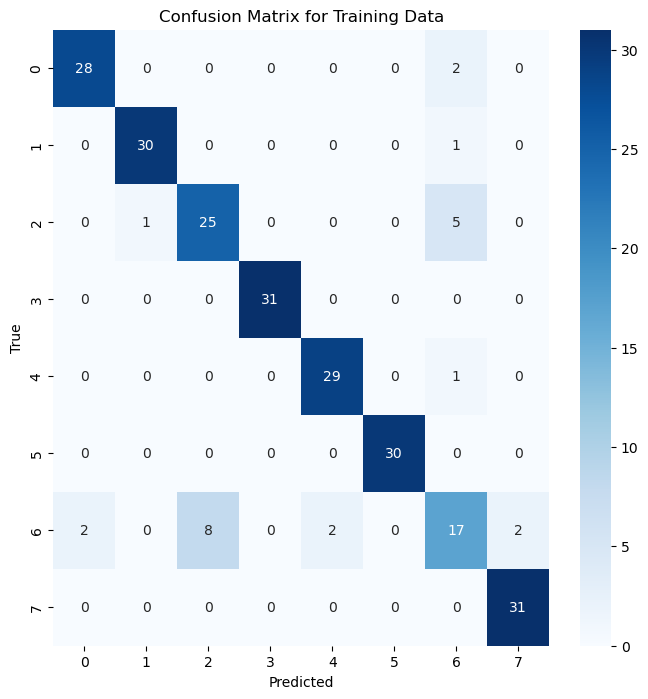

In [87]:
# Plot
plt.figure(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Training Data')
plt.show()


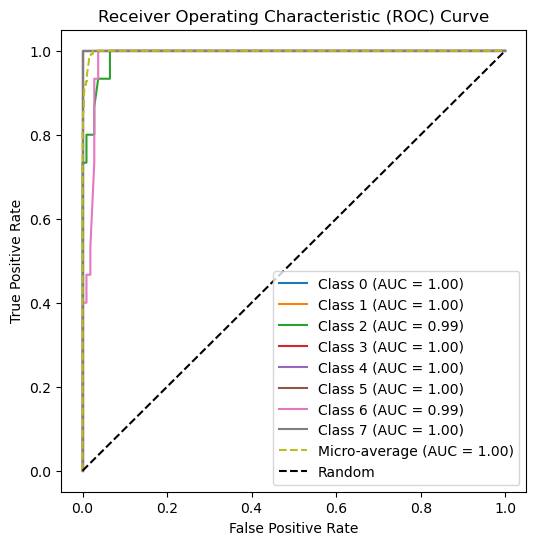

In [88]:


#Binarize true labels
y_test_binarized = label_binarize(Y_test, classes=np.unique(Y_test))


#ROC curve and AUC scores for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(Y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), test_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

#Plot
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
for i in range(len(np.unique(Y_test))):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:0.2f})'.format(i, roc_auc[i]))

plt.plot(fpr_micro, tpr_micro, label='Micro-average (AUC = {:0.2f})'.format(roc_auc_micro), linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [89]:
grad = estimator.fit(X_train,Y_train)
test_prob = grad.predict_proba(X_test)

In [90]:
y_pred_test=np.argmax(test_prob,axis=1)
y_pred_test

array([1, 6, 0, 7, 3, 0, 0, 1, 7, 0, 4, 5, 6, 7, 0, 1, 2, 1, 5, 0, 0, 3,
       4, 4, 4, 7, 1, 2, 2, 7, 1, 5, 2, 5, 1, 7, 7, 2, 2, 4, 4, 7, 5, 0,
       6, 0, 2, 2, 6, 3, 2, 1, 3, 2, 2, 5, 4, 2, 6, 1, 5, 4, 3, 3, 3, 3,
       0, 1, 2, 7, 3, 3, 5, 2, 2, 5, 7, 1, 4, 5, 1, 0, 3, 4, 5, 6, 0, 3,
       0, 4, 2, 3, 3, 6, 7, 4, 4, 4, 5, 7, 4, 5, 0, 4, 0, 0, 2, 7, 1, 5,
       6, 6, 7, 1, 6, 7, 2, 5, 6, 1, 5, 3, 6], dtype=int64)

In [91]:
conf_mat = confusion_matrix(Y_test,y_pred_test) #true_labels, predicted_labels
print(conf_mat)

macro_avg_sens, macro_avg_spec = scores(conf_mat)

print("Macro-average Sensitivity:", macro_avg_sens)
print("Macro-average Specificity:", macro_avg_spec)

[[15  0  0  0  0  0  1  0]
 [ 0 15  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  3  0]
 [ 0  0  0 15  0  0  0  0]
 [ 0  0  0  0 16  0  0  0]
 [ 0  0  0  0  0 16  0  0]
 [ 1  0  6  0  0  0  8  0]
 [ 0  0  0  0  0  0  0 15]]
Macro-average Sensitivity: 0.9088541666666666
Macro-average Specificity: 0.9088541666666666


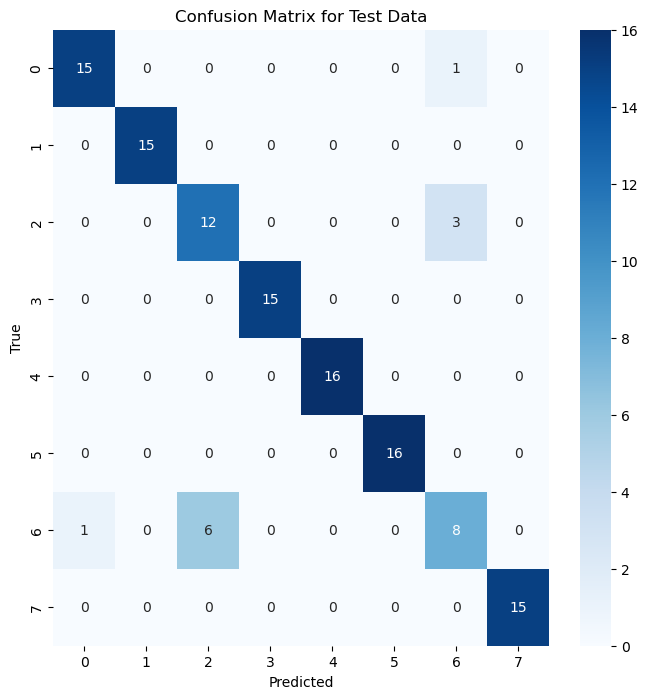

In [92]:
# Plot
plt.figure(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Test Data')
plt.show()


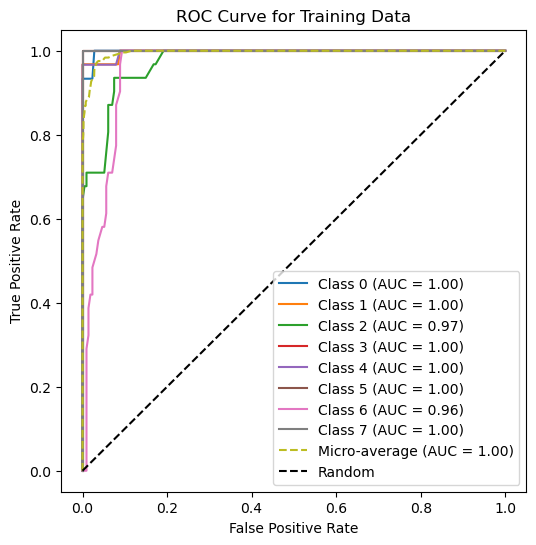

In [93]:
#Binarize true labels
y_train_binarized = label_binarize(Y_train, classes=np.unique(Y_train))


#ROC curve and AUC scores for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(Y_train))):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_train_binarized.ravel(), probabilities.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

#Plot
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
for i in range(len(np.unique(Y_train))):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:0.2f})'.format(i, roc_auc[i]))

plt.plot(fpr_micro, tpr_micro, label='Micro-average (AUC = {:0.2f})'.format(roc_auc_micro), linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data')
plt.legend(loc='lower right')
plt.show()


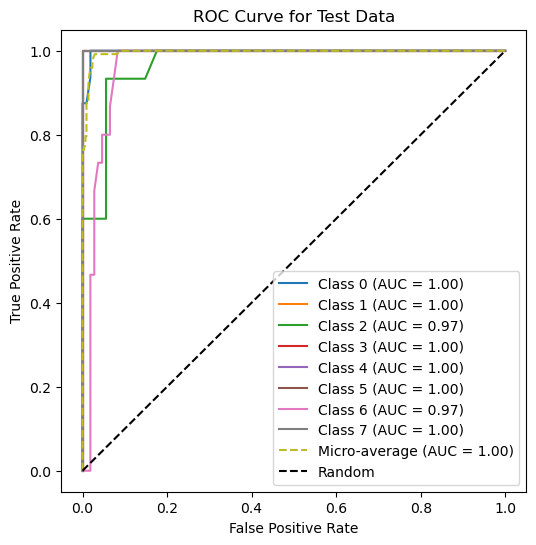

In [94]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#Binarize true labels
y_test_binarized = label_binarize(Y_test, classes=np.unique(Y_test))


#ROC curve and AUC scores for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(Y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), test_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

#Plot
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
for i in range(len(np.unique(Y_test))):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:0.2f})'.format(i, roc_auc[i]))

plt.plot(fpr_micro, tpr_micro, label='Micro-average (AUC = {:0.2f})'.format(roc_auc_micro), linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Data')
plt.legend(loc='lower right')
plt.show()


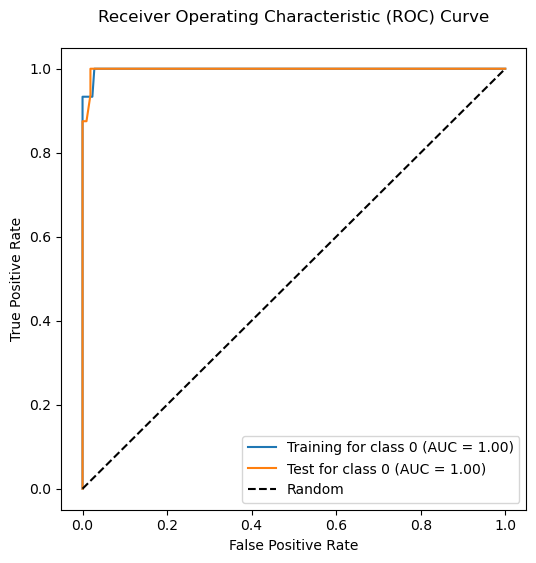

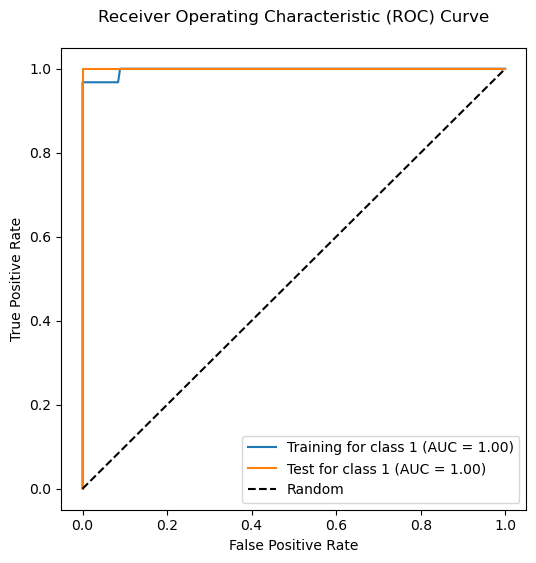

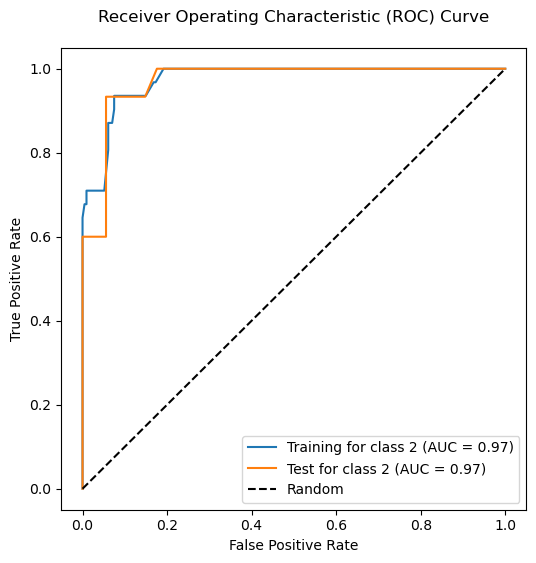

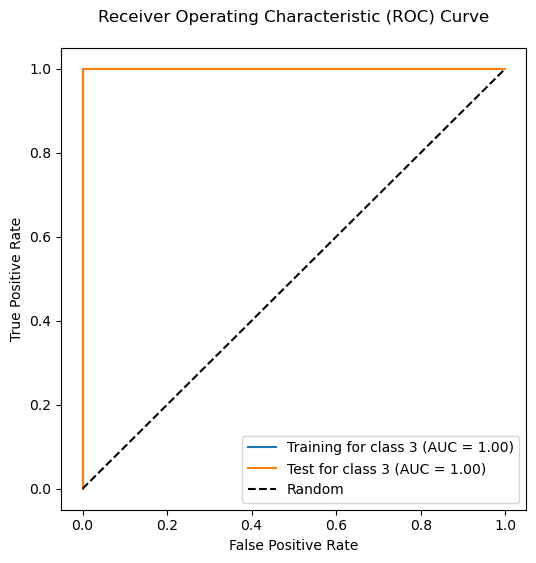

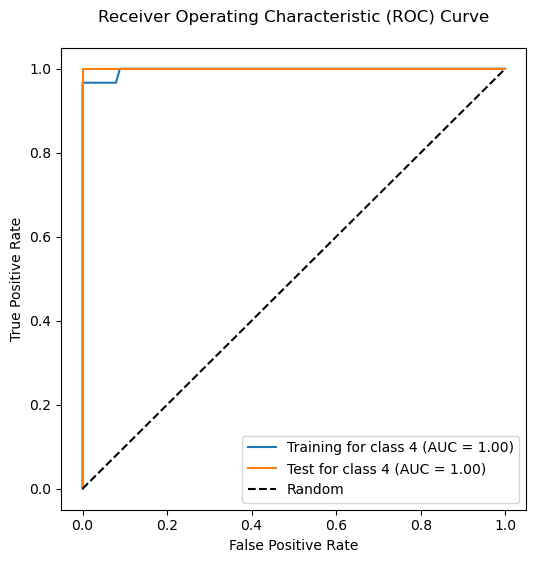

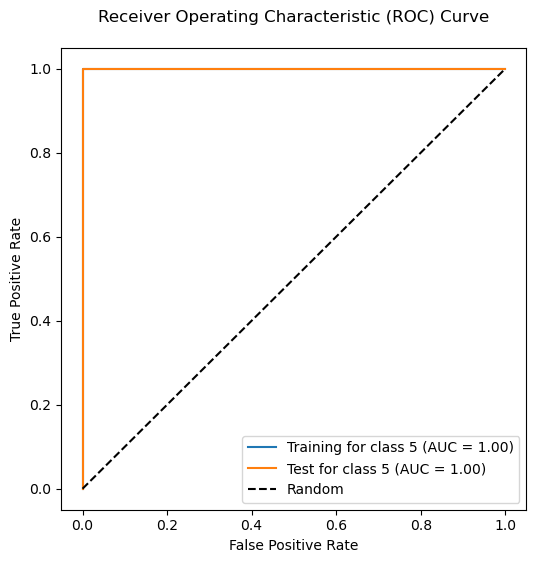

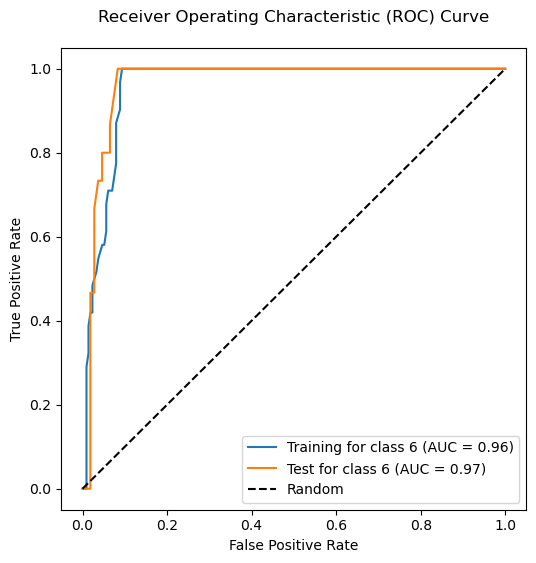

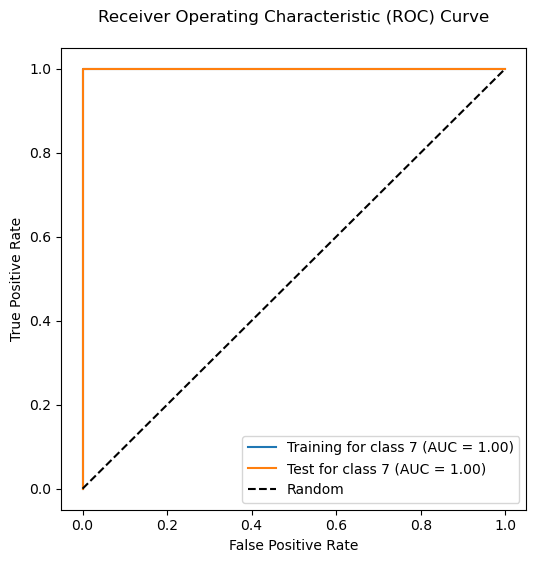

In [95]:
# Binarize true labels
y_test_binarized = label_binarize(Y_test, classes=np.unique(Y_test))
y_train_binarized = label_binarize(Y_train, classes=np.unique(Y_test))

# ROC curve and AUC scores for each class in the test data
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(Y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC curve and AUC scores for each class in the training data
fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()
for i in range(len(np.unique(Y_train))):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_binarized[:, i], probabilities[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# Plot ROC curves for each class
sub = np.unique(Y_test)
for i in range(len(np.unique(Y_test))):
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
    plt.plot(fpr_train[i], tpr_train[i], label='Training for class %s (AUC = %0.2f)' % (sub[i], roc_auc_train[i]))
    plt.plot(fpr[i], tpr[i], label='Test for class %s (AUC = %0.2f)' % (sub[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve\n')
    plt.legend(loc='lower right')
    plt.show()

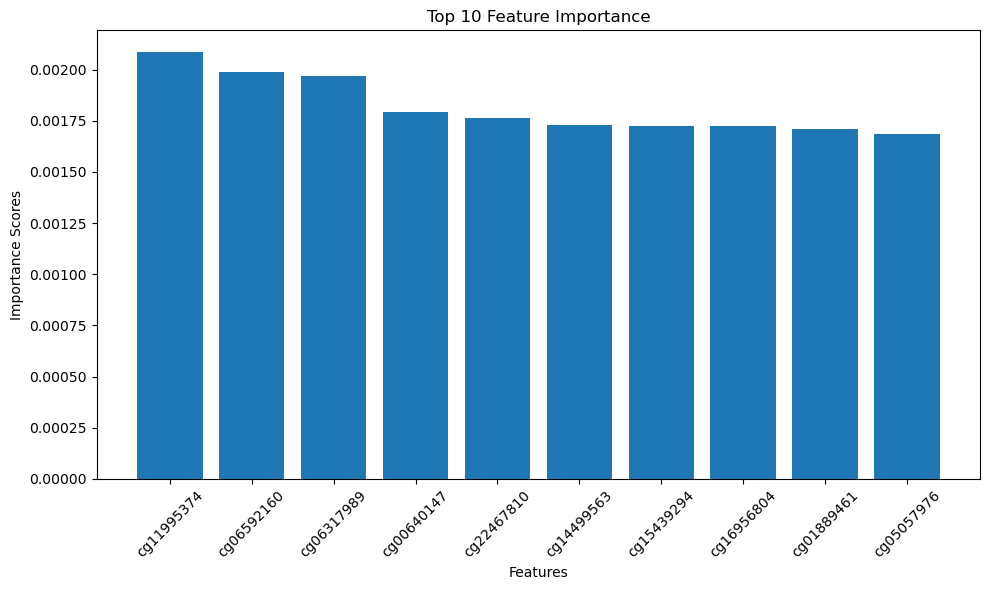

In [96]:
import matplotlib.pyplot as plt

importance_scores = grad.feature_importances_

# Sort the features by their importance scores
sorted_indices = importance_scores.argsort()[::-1]
sorted_features = X_train.columns[sorted_indices]

# Select the top 10 features and their importance scores
top_features = sorted_features[:10]
top_scores = importance_scores[sorted_indices][:10]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(top_features, top_scores)
plt.xlabel('Features')
plt.ylabel('Importance Scores')
plt.title('Top 10 Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()